# Analysis via zoom into protostars and cutouts of the N$_2$H$^+$ cube
The same we did for HC3N but we separate the files to keep order

In [1]:
import numpy as np
import os
import astropy.units as u
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord, FK5
from astropy.nddata.utils import Cutout2D
from spectral_cube import SpectralCube
import pandas as pd
from glob import glob
from pvextractor import PathFromCenter, Path, extract_pv_slice

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import cm
%matplotlib widget

sourcecat = '../../data/my_catalog_vel.csv'
cubefile = '../../data/NGC1333-N2Hp_match_kms_F1F_01_12.fits'
mlex1file = '../../bayes_frame/nested-sampling/N2Hp/NGC1333-SE-mle-x1_filtered_QA.fits'
mlex2file = '../../bayes_frame/nested-sampling/N2Hp/NGC1333-SE-mle-x2_filtered_QA.fits'
#I think in some cases we also need the clusters
cut_clusters = True
clusters_n2hp_files = ['../../clustering/cluster_blue_HDBSCAN_N2Hp.fits', '../../clustering/cluster_red_HDBSCAN_N2Hp.fits'] #sorted(glob('../../clustering/cluster*[0-9]_HDBSCAN_N2Hp.fits'))


radiuscut_au = 10000
distance = 298 # pc
radiuscut = radiuscut_au / distance *u.arcsec # 

In [2]:
cube = SpectralCube.read(cubefile)
wcsskycube = WCS(cube.header).celestial

mlex1, mlex1head = fits.getdata(mlex1file, header=True)
mlex2, mlex2head = fits.getdata(mlex2file, header=True)

if cut_clusters:
    cluster_n2hp_master = [fits.getdata(filein) for filein in clusters_n2hp_files]
    cluster_head = fits.getheader(clusters_n2hp_files[0])

catalog_protostars = pd.read_csv(sourcecat)


In [95]:
sourcename = 'SVS13A'
catalogno = 6
racent, deccent = catalog_protostars.loc[catalogno, ['RAJ2000', 'DEJ2000']].values
subcubes_basename = sourcename + '_N2Hp_{}'
vlsr = catalog_protostars.loc[catalogno, 'vlsr']

In [96]:
# here we cut the images
centerx, centery = wcsskycube.all_world2pix([racent], [deccent], 0)
centerx, centery = int(centerx[0]), int(centery[0])

radiuspix = int(np.round(radiuscut.to(u.deg).value / np.abs(cube.header['CDELT2']), 0))

In [97]:
if not os.path.exists(subcubes_basename.format('cube.fits')):
    subcube = cube[:, centery-radiuspix:centery+radiuspix, centerx-radiuspix:centerx+radiuspix]
    subcube.write(subcubes_basename.format('cube.fits'))
else:
    subcube = SpectralCube.read(subcubes_basename.format('cube.fits'))
headersmall = subcube.header
headersmall_mle = WCS(headersmall).celestial.to_header()
headersmall_mle['NAXIS'] = 3
headersmall_mle['BUNIT'] = 'km s-1'
headersmall_mle['BMAJ'] = headersmall['BMAJ']
headersmall_mle['BMIN'] = headersmall['BMIN']
headersmall_mle['BPA'] = headersmall['BPA']
headersmall_mle['RESTFREQ'] = headersmall['RESTFREQ']

In [98]:

if not os.path.exists(subcubes_basename.format('mlex1.fits')):
    submlex1 = mlex1[:, centery-radiuspix:centery+radiuspix, centerx-radiuspix:centerx+radiuspix]
    headersmall_mle['NAXIS3'] = 6
    fits.writeto(subcubes_basename.format('mlex1.fits'), submlex1, headersmall_mle)
else:
    submlex1, headersmall_mle = fits.getdata(subcubes_basename.format('mlex1.fits'), header=True)

if not os.path.exists(subcubes_basename.format('mlex2.fits')):
    submlex2 = mlex2[:, centery-radiuspix:centery+radiuspix, centerx-radiuspix:centerx+radiuspix]
    headersmall_mle['NAXIS3'] = 12
    fits.writeto(subcubes_basename.format('mlex2.fits'), submlex2, headersmall_mle)
else:
    submlex2, headersmall_mle = fits.getdata(subcubes_basename.format('mlex2.fits'), header=True) 


In [99]:
if cut_clusters:
    subclusters_master = []
    for i, cluster in enumerate(cluster_n2hp_master):
        if not os.path.exists(subcubes_basename.format('cluster{}.fits'.format(i))):
            subcluster = cluster[:, centery-radiuspix:centery+radiuspix, centerx-radiuspix:centerx+radiuspix]
            if np.isnan(subcluster).all(): continue
            else:
                subclusters_master.append(subcluster)
                headersmall_mle['NAXIS3'] = 6
                fits.writeto(subcubes_basename.format('cluster{}.fits'.format(i)), subcluster, headersmall_mle)
        else:
            subclusters_master.append(fits.getdata(subcubes_basename.format('cluster{}.fits'.format(i))))

## Exploration plots

In [100]:
# pv diagrams

pa_angle = (140+90)*u.deg #degrees from north
widtharcsec = (cube.header['bmaj'] * u.deg).to(u.arcsec)
# centerxdeg, centerydeg = catalog_protostars.loc[catalogno, 'RAJ2000']*u.deg, catalog_protostars.loc[catalogno, 'DEJ2000']*u.deg
racent, deccent = catalog_protostars.loc[catalogno, ['RAJ2000', 'DEJ2000']] * u.deg
length = (10000 / 293 *u.arcsec).to(u.deg)
gcent = SkyCoord(racent, deccent)
pvfilename = subcubes_basename.format('pvdiag.fits')
pathcent = PathFromCenter(center=gcent, length=length, angle=pa_angle, width=widtharcsec)
slice1 = extract_pv_slice(cube, pathcent)
slice1.header['CRPIX1'] = int(slice1.header['NAXIS1']/2) # by default the reference offset is the first pixel
slice1.writeto(pvfilename, overwrite=True)

In [101]:
pvarcsecfilename = subcubes_basename.format('pvdiag_arcsec.fits')
pvheader = fits.getheader(pvfilename)
pvdata = np.flip(slice1.data, axis=0) # so that the velocities grow instead of decreasing
pvheader['CDELT1'] = pvheader['CDELT1']*3600 # change to arcsec
pvheader['CUNIT1'] = 'arcsec'
if np.sign(pvheader['CDELT2'])<0:
    velinit = pvheader['CRVAL2'] + pvheader['CDELT2'] * (pvheader['NAXIS2'] - pvheader['CRPIX2']) # this is the velocity in the new first pixel
    pvheader['CRPIX2'] = 1 # the first pixel is our new reference
    pvheader['CRVAL2'] = velinit # the first pixel will have the lowest velocity
    pvheader['CDELT2'] *= -1 
hdu = fits.PrimaryHDU(data=pvdata, header=pvheader)
hdu.writeto(pvarcsecfilename, overwrite=True)

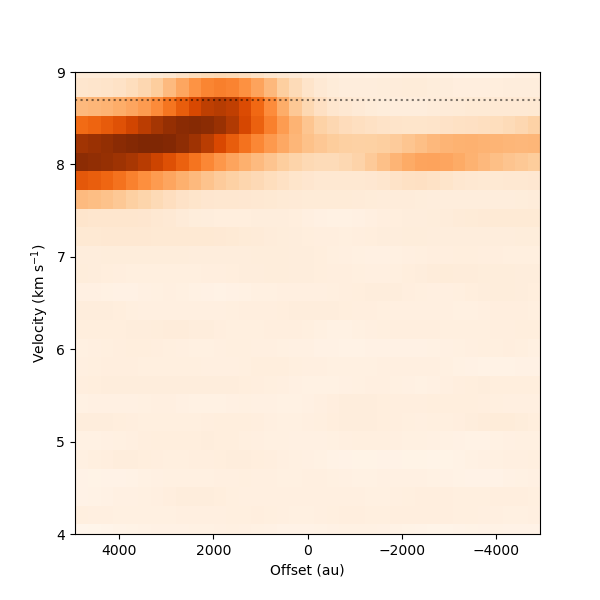

In [102]:
delta0 = pvheader['CRVAL1']
delta_delta = pvheader['CDELT1']
delta_pix0 = pvheader['CRPIX1']
delta_npix = pvheader['NAXIS1']
vel0 = pvheader['CRVAL2']
delta_vel = pvheader['CDELT2']
vel_pix0 = pvheader['CRPIX2']
vel_npix = pvheader['NAXIS2']


delta_array = np.array([delta0 + delta_delta*(i-delta_pix0) for i in range(delta_npix)]) * u.arcsec
vel_array = np.array([vel0 + delta_vel * (i - vel_pix0) for i in range(vel_npix)]) * u.m/u.s
vel_array = vel_array.to(u.km/u.s)
distance_array = (delta_array).value * 293 * u.au 
# we create the meshgrid to plot
offset, vel = np.meshgrid(distance_array, vel_array)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
pcolor = ax.pcolor(offset.value, vel.value, pvdata, shading='auto', cmap='Oranges')
ax.axhline(vlsr, color='k', ls=':', alpha=0.5)
ax.set_xlabel('Offset (au)')
ax.set_ylabel(r'Velocity (km s$^{-1}$)')
ax.set_ylim([4,9])
ax.invert_xaxis()